#### Problem Overview:
Johnny’s Jeans is a fashion start-up and a new customer of ActionIQ. The first campaign they want to create on our platform is a Thank-You message to all their first customers. They want to target their first 10,000 customers and send them some stats about their first year of sales.

The Johnny’s Jeans finance team reported that the first 10,000 customers spent a collective $33,904,525 on their site. 

However when the marketing team ran the sum of total revenue on the AIQ platform, the total sum was a bit less at $29,162,044. The Johnny’s Jeans marketing team was concerned about this data discrepancy and has reached out to AIQ.

#### Background of our integration with Johnny’s Jeans:
1. Every few weeks, Johnny’s Jeans data warehouse does an export of their most recent rows from their user-summary table. This data is encrypted and dropped into an AWS S3 bucket.

2. AIQ’s server is designed to ping that S3 bucket every 24 hours and when a new file is dropped, AIQ’s system is supposed to retrieve the new file for decryption.

3. The decrypted user-summary data is in a CSV with these fields:

    a. user_id
    b. Total_spend (total this user has spent at Johnny’s Jeans)
    c. count_saved_items (total amount of book-marked items)
    d. loyalty_credits (amount of loyalty points the user can spend)
    e. batch_id
    
4. AIQ’s

the data by choosing the largest batch_id for each user. This ensures that AIQ should only be loading 1 row per user.
data pipeline is designed to read through all the data files and de-duplicate

5. Once that data is de-duplicated, it is loaded into AIQ’s platform and is ready for users to start running queries.

#### Task Notes:
1. We have provided the 5 of the decrypted files that were sent to us by Johnny’s Jeans.

    a. Delta0.csv was their initial base set of data.
    b. Deltas 1-4 were their update files.
2. We have also sent you AIQ’s version of their user-summary table(AIQ-user-summary.csv). Johnny Jeans’ has exported the table on their end and we’ve sent you that as well (Johnny-user-summary.csv).


#### Prompt 1. Figure out best you can what the problem is. Bear in mind that just like any software engineering effort, AIQ is not immune to bugs and things may not work perfectly as expected:

#### Let's begin by loading the data in and taking a look at our two conflicting summaries, AIQ_User_Summary and J_User_Summary:


In [1]:
import numpy as np
import pandas as pd

In [2]:
AIQ_User_Summary = pd.read_csv('/Users/ir3n3br4t515/Desktop/AIQ-user-summary.csv')
J_User_Summary = pd.read_csv('/Users/ir3n3br4t515/Desktop/Johnny-user-summary.csv')
D_0 = pd.read_csv('/Users/ir3n3br4t515/Desktop/delta0.csv')
D_1 = pd.read_csv('/Users/ir3n3br4t515/Desktop/delta1.csv')
D_2 = pd.read_csv('/Users/ir3n3br4t515/Desktop/delta2.csv')
D_3 = pd.read_csv('/Users/ir3n3br4t515/Desktop/delta3.csv')
D_4 = pd.read_csv('/Users/ir3n3br4t515/Desktop/delta4.csv')




In [3]:
AIQ_User_Summary.head()

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,5988,3500,12,517,3164
1,5989,775,17,613,298
2,5982,1749,8,386,1489
3,5983,3061,7,905,4271
4,5980,3852,48,938,3496


In [4]:
AIQ_User_Summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
user_id              10000 non-null int64
total_spend          10000 non-null int64
count_saved_items    10000 non-null int64
loyalty_credits      10000 non-null int64
batch_id             10000 non-null int64
dtypes: int64(5)
memory usage: 390.8 KB


In [5]:
J_User_Summary.head()

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,5988,4208,20,287,5731
1,5989,775,17,613,298
2,5982,1749,8,386,1489
3,5983,4537,17,151,4623
4,5980,3852,48,938,3496


In [6]:
J_User_Summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
user_id              10000 non-null int64
total_spend          10000 non-null int64
count_saved_items    10000 non-null int64
loyalty_credits      10000 non-null int64
batch_id             10000 non-null int64
dtypes: int64(5)
memory usage: 390.8 KB


In [7]:
AIQ_Total = AIQ_User_Summary['total_spend'].sum()

print (AIQ_Total)

29162044


In [8]:
J_Total = J_User_Summary['total_spend'].sum()

print (J_Total)

33904525


In [9]:
J_Total - AIQ_Total

4742481

#### Great! So we are looking for a discrepancy of $4,742,281. 

#### Let's see if we can pinpoint a few more differences by isolating exactly what's not adding up. We see below that there is a discrepancy in our 'total_spend' columns, which we already knew, lets see how many of the rows in this column are affected. 

In [10]:

J_User_Summary['total_spend'].equals(AIQ_User_Summary['total_spend'])



False

In [11]:
df1 = J_User_Summary
df2 = AIQ_User_Summary

In [12]:
df2.head(1)

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,5988,3500,12,517,3164


In [13]:
df1.head(1)

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,5988,4208,20,287,5731


In [14]:
intersection = pd.merge(df1.reset_index(), df2.reset_index(), on=['index','total_spend'], how='inner')
df1[~df1.index.isin(intersection['index'])] - df2[~df2.index.isin(intersection['index'])]



,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,0,708,8,-230,2567
3,0,1476,10,-754,352
10,174,540,18,-702,-591
11,-1,3895,-11,-424,3837
12,3,-6141,-35,549,-5722
...,...,...,...,...,...
9995,-1,2888,-9,-19,3086
9996,-1,2951,-13,195,2900
9997,-1,-1685,36,-263,-209
9998,-1,-2151,-1,-143,-2471


In [15]:
(df1[~df1.index.isin(intersection['index'])]['total_spend'] - df2[~df2.index.isin(intersection['index'])]['total_spend']).sum()


4742481

#### Ok, so our analysis above proved that almost every row (9969 to be exact) had a delta between the two user summary reports from AIQ and Johnny's. The sum of these discrepancies was exactly $4,742,481 which means we can trust the differences we see in the table of cell 13. 

Now let's take a look at the batch_id unique values for each of our User Summarys for comparison. AIQ’s data pipeline is designed to read through all the data by choosing the largest batch_id for each user. This ensures that AIQ should only be loading 1 row per user, let's see if that's the case with Johnny's Jeans user summary:

In [16]:
len(AIQ_User_Summary['batch_id'].unique().tolist())


5021

In [17]:
len(J_User_Summary['batch_id'].unique().tolist())


5667

In [18]:
5667 - 5021

646

#### Great, that solves a bit of our discrepancy. There are 646 more batch_id values in the J_User_Summary than there are in the AIQ_User_Summary. 

#### This suggests Johnny's Jeans has allowed multiple entries for each user, however they both have the same number of user_ids, 10,000 per file based on the two cells below:



In [19]:
len(AIQ_User_Summary['user_id'].unique().tolist())


10000

In [20]:
len(J_User_Summary['user_id'].unique().tolist())


10000

#### Now let's move onto the delta files from Johnny's to see if they give us any further insight, and to confirm if this is also the case there as well. If it is, we should see different values for batch_id there as well.  I am most curious to see if the batch_ids from these files add up to the number of unique batch_ids from Johnny's user summary. 

In [21]:
D0_Total = D_0['total_spend'].sum()

print (D0_Total)

9993346


In [22]:
D_0.head()

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,1,1119,34,109,1536
1,2,271,4,305,1223
2,3,390,15,113,105
3,4,1689,39,690,1042
4,5,70,9,154,6


In [23]:
D_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
user_id              10000 non-null int64
total_spend          10000 non-null int64
count_saved_items    10000 non-null int64
loyalty_credits      10000 non-null int64
batch_id             10000 non-null int64
dtypes: int64(5)
memory usage: 390.8 KB


In [24]:
D0_Total = D_0['total_spend'].sum()

print (D0_Total)

9993346


In [25]:
len(D_0['user_id'].unique().tolist())


10000

In [26]:
len(D_0['batch_id'].unique().tolist())


1989

#### So far, we see 1989 unique batch_id values and 10,000 user_ids. Let's see if this trend continues with the remaining files. 

In [27]:
D_1.head()

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,8195,2662,36,263,2948
1,8196,2804,19,156,2071
2,10,2862,48,660,2019
3,8203,2231,49,866,2231
4,8206,2731,23,446,2367


In [28]:
D_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 5 columns):
user_id              2494 non-null int64
total_spend          2494 non-null int64
count_saved_items    2494 non-null int64
loyalty_credits      2494 non-null int64
batch_id             2494 non-null int64
dtypes: int64(5)
memory usage: 97.5 KB


In [29]:
D1_Total = D_1['total_spend'].sum()

print (D1_Total)

6212911


In [30]:
len(D_1['user_id'].unique().tolist())


2494

In [31]:
len(D_1['batch_id'].unique().tolist())


919

#### Confirmed here as well, 919 batch_ids to 2494 user_ids (one for each row)

In [32]:
D_2.head()

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,8194,3169,14,123,3456
1,6,3907,11,659,3202
2,7,3561,16,694,3157
3,8,3340,17,289,3489
4,11,3626,41,454,4375


In [33]:
D_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 5 columns):
user_id              2519 non-null int64
total_spend          2519 non-null int64
count_saved_items    2519 non-null int64
loyalty_credits      2519 non-null int64
batch_id             2519 non-null int64
dtypes: int64(5)
memory usage: 98.5 KB


In [34]:
D2_Total = D_2['total_spend'].sum()

print (D2_Total)

8820088


In [35]:
len(D_2['user_id'].unique().tolist())


2519

In [36]:
len(D_2['batch_id'].unique().tolist())


1210

#### Confirmed here as well, 1210 batch_ids to 2519 user_ids (one for each row)

In [37]:
D_3.head()

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,1,4070,10,179,4940
1,3,4558,43,736,4510
2,8199,4663,8,728,4996
3,8,4991,24,480,5107
4,9,4379,16,148,4673


In [38]:
D_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 5 columns):
user_id              2473 non-null int64
total_spend          2473 non-null int64
count_saved_items    2473 non-null int64
loyalty_credits      2473 non-null int64
batch_id             2473 non-null int64
dtypes: int64(5)
memory usage: 96.7 KB


In [39]:
D3_Total = D_3['total_spend'].sum()

print (D3_Total)

11131828


In [40]:
len(D_3['user_id'].unique().tolist())


2473

In [41]:
len(D_3['batch_id'].unique().tolist())


1225

#### Confirmed here as well, 1225 batch_ids to 2473 user_ids (one for each row)

In [42]:
D_4.head()

,user_id,total_spend,count_saved_items,loyalty_credits,batch_id
0,8194,5105,40,402,6355
1,5,6755,3,360,7785
2,8198,6331,19,841,7210
3,8,6186,39,947,6789
4,10,5498,39,821,7966


In [43]:
D_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 5 columns):
user_id              2483 non-null int64
total_spend          2483 non-null int64
count_saved_items    2483 non-null int64
loyalty_credits      2483 non-null int64
batch_id             2483 non-null int64
dtypes: int64(5)
memory usage: 97.1 KB


In [44]:
D4_Total = D_4['total_spend'].sum()

print (D4_Total)

14897837


In [45]:
len(D_4['user_id'].unique().tolist())


2483

In [46]:
len(D_4['batch_id'].unique().tolist())


1439

#### Finally, with our last update file, we finish the trend here as well, 1439 batch_ids to 2483 user_ids (one for each row).  Below we see the unique values within each update file and I am struggling to see how these add up to the Johnny's user summary total of 5667 unique batch_ids.

In [47]:
1439 + 1225 + 1210 + 919 + 1989 

6782

#### Ok! This gives us some idea of what's been happening based on the files we've received. 

While AIQ dedupes the data by choosing the largest batch_id for each user, Johnny's internal systems are not doing this. Perhaps they tried to do this subsequently with their update files. The initial dive we took into the difference between the two user summaries suggests the problem resides within those additional batch_ids that are included in the Johnny's Jeans user summary which are not included in the AIQ user summary. They may be trying to account for this discrepancy with their update files, but this is not bridging the gap. 

#### Now let's communicate some of these findings to our clients. 

#### Prompt 2. You are writing an email to the AIQ backend engineer describing what you’ve found and what you think the issue here is. Please provide as much information and/or examples as possible.

Hi Jack, 

I hope you had a good weekend! 

I was just taking a look at Johnny's Jeans discrepancy issue. The Johnny’s Jeans finance team reported that the first 10,000 customers spent a collective ($33,904,525) 

on their site, but when marketing ran the sum of total revenue on our platform, the total sum was a bit less at ($29,162,044).

It seems the issue is with the batch_id and total_cost columns:

 - Total_cost: Almost every row in the 'total_cost" column (9969 to be exact) had a delta between the two user summary reports from AIQ and Johnny's. The sum of these discrepancies was exactly $4,742,481, which is exactly how much Johnny's Jeans numbers were off by.


 - Batch_id: When comparing unique values for each of our User Summarys, AIQ’s data pipeline is designed to read through all the data by choosing the largest batch_id for each user. This ensures that AIQ should only be loading 1 row per user, as you know, but that's not the case with Johnny's Jeans user summary. There are 646 more batch_id values in the J_User_Summary than there are in the AIQ_User_Summary, suggesting Johnny's Jeans has allowed multiple entries for each user, however they both have the same number of user_ids, 10,000 per file.

When I took a look at their update delta files, I was still not able to account for this difference. Here's a snapshot of some of these deltas between the two user summaries:

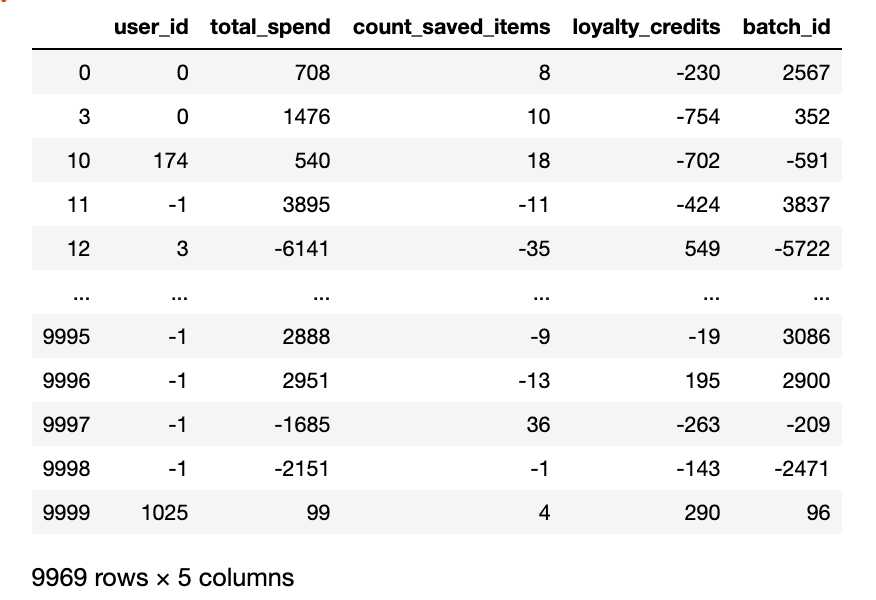

Let me know if there's any more info I can send your way or if you have a few minutes to chat about this today. 

Thanks!
Irene

#### Prompt 3. Michael Greene, Johnny Jean’s email marketing director, emailed us asking why our data doesn’t seem to be matching up with theirs. Write a response for him.

Hi Michael, 

Thanks for reaching out about this, I hope you had a great weekend!

I want to make sure we can get down to the bottom of the discrepancies you're seeing, your trust in our platform is of upmost importance to me. I took a look at our two user summaries and found a couple of things: 

 - It appears our user summaries both show 10,000 unique user_ids, which is great. When I dive into the batch_ids, I am showing about 646 additional batch_ids in your summary, which concerned me because we make sure to filter those out and select the largest batch_id for each user so that there aren't duplicates. 


 - I was also noticing differences in the total_cost columns between our two summaries, even where the user_id was the same. 

Let me know when you might have some time this week to talk about this. I'd like to get a better understanding of where the disconnect is and make sure we can see a single source of truth on both our ends. 

Talk soon, 

Irene
